In [16]:
pose_label_path = '../data/labels/all_images/'
bbox_label_path = '../data/bbox_labels/all_images/'
keypoint_labels_path = '../data/key_point_labels/labels_2016.csv'

In [17]:
# with open(keypoint_labels_path, mode='r') as file:
#     csv_reader = csv.DictReader(file)
#     for row in csv_reader:
#         print(row)

In [18]:
# import csv 
  
# # Open file  
# with open(keypoint_labels_path) as file_obj: 
      
#     # Create reader object by passing the file  
#     # object to reader method 
#     reader_obj = csv.reader(file_obj) 
      
#     # Iterate over each row in the csv  
#     # file using reader object 
#     for row in reader_obj: 
#         print(row)

# Code for creating a dictonary for bbox values

Dictonary format => filename as key and list of tuples of bbox co-ordinate for each whale as value


{
filename:[(a,b,c,d),(e,f,g,h)....]
}


In [19]:
import pandas as pd

keypoints_df = pd.read_csv(keypoint_labels_path)

keypoints_df.columns

Index(['Unnamed: 0', 'filename', 'whale_id', 'rostrum_x', 'rostrum_y',
       'side1_head1_x', 'side1_head1_y', 'side1_head2_x', 'side1_head2_y',
       'side1_eye_x', 'side1_eye_y', 'side1_body1_x', 'side1_body1_y',
       'side1_body2_x', 'side1_body2_y', 'side1_body3_x', 'side1_body3_y',
       'side1_peduncle_width_x', 'side1_peduncle_width_y', 'peduncle_x',
       'peduncle_y', 'side2_peduncle_width_x', 'side2_peduncle_width_y',
       'side2_body3_x', 'side2_body3_y', 'side2_body2_x', 'side2_body2_y',
       'side2_body1_x', 'side2_body1_y', 'side2_eye_x', 'side2_eye_y',
       'side2_head2_x', 'side2_head2_y', 'side2_head1_x', 'side2_head1_y',
       'blowhole_x', 'blowhole_y', 'len_mid_x', 'len_mid_y', 'fluke_x',
       'fluke_y', 'Image.Length', 'Image.Width'],
      dtype='object')

,Unnamed: 0,filename,whale_id,rostrum_x,rostrum_y,side1_head1_x,side1_head1_y,side1_head2_x,side1_head2_y,side1_eye_x,...,side2_head1_x,side2_head1_y,blowhole_x,blowhole_y,len_mid_x,len_mid_y,fluke_x,fluke_y,Image.Length,Image.Width
234,234,2016.08.03.420.04.JPG,1,540.0,2407.0,695.0,2532.0,953.0,2598.0,1120.0,...,659.0,2270.0,922.0,2419.0,1718.0,2413.0,2954.0,2183.0,3456,4608


In [21]:
bbox_dict = dict()
for index,row in keypoints_df.iterrows():
    filename = row.filename[:-4]
    value = bbox_dict.get(filename,list())
    with open(bbox_label_path+filename+'.txt', 'r') as file:
        for line in file:
            components = line.split()
            cx, cy, w, h = [float(x) for x in components[1:5]]
            bbox = (cx,cy,w,h)
            value.append(bbox)
    bbox_dict[filename]=value

    

In [22]:
print(len(bbox_dict))

468


# Below cells contain code for 

1: matching whale bbox to correct whale in keypoints csv
2: Creating a file for each image and adding the yolov8-pose format keypoint data to it.

<h4>Yolov8 Pose Format</h4>
class-index, bbox_values, keypoint_values

keypoint_values can be 2D or 3D.
2D => x,y
3D => x,y,visibility

In [23]:
def match_whale_bbox(bboxes,mid_x,mid_y):
    min_index = 0
    min_dist=999999
    for i in range(len(bboxes)):
        cx,cy,_,_ = bboxes[i]
        dist =( (cx-mid_x)**2 + (cy-mid_y)**2 )**(1/2)
        if(dist<min_dist):
            min_dist = dist
            min_index = i
    return i
    
    

In [27]:
def normalize(keypoints,h,w):
    n = len(keypoints)
    visibility=n//2
    norm = [1]*(n+visibility)
    for i in range(0,n,2):
        norm[i+i//2]=keypoints[i]/w
    for i in range(1,n,2):
        norm[i+i//2]=keypoints[i]/h
    return norm
        

In [28]:
cnt=0
cls=0
for index,row in keypoints_df.iterrows():
    filename = row.filename[:-4]
    print("File Name: ",filename)
    print("bbox dict: ",  bbox_dict[filename])
    h,w = row['Image.Length'], row['Image.Width']
    index = 0
    if len(bbox_dict[filename])>1:
        index = match_whale_bbox(bbox_dict[filename],row.len_mid_x,row.len_mid_y)
    print("Matched index: ",index)
    keypoints = normalize(list(row['rostrum_x':'fluke_y'].values),h,w)
    bbox = bbox_dict[filename][index]
    bbox_dict[filename].pop(index)
    pose = [cls]
    pose.extend(bbox)
    pose.extend(keypoints)
    print("Len of pose: ",len(pose))
    with open(pose_label_path+filename+'.txt', 'a') as file: 
        file.write(' '.join(map(str, pose)) + '\n')
    
    
    
    
        
        


File Name:  2016.06.25.06.01
bbox dict:  [(0.431137, 0.509709, 0.431589, 0.316817)]
Matched index:  0
Len of pose:  62
File Name:  2016.06.25.13.01
bbox dict:  [(0.448391, 0.431564, 0.680966, 0.412458), (0.551563, 0.599074, 0.226324, 0.185185)]
Matched index:  1
Len of pose:  62
File Name:  2016.06.25.16.01
bbox dict:  [(0.513732, 0.226937, 0.41373, 0.275926), (0.475426, 0.129377, 0.16288, 0.087542), (0.606961, 0.490488, 0.439395, 0.375421), (0.513732, 0.226937, 0.41373, 0.275926), (0.475426, 0.129377, 0.16288, 0.087542), (0.606961, 0.490488, 0.439395, 0.375421)]
Matched index:  5
Len of pose:  62
File Name:  2016.06.25.16.01
bbox dict:  [(0.513732, 0.226937, 0.41373, 0.275926), (0.475426, 0.129377, 0.16288, 0.087542), (0.606961, 0.490488, 0.439395, 0.375421), (0.513732, 0.226937, 0.41373, 0.275926), (0.475426, 0.129377, 0.16288, 0.087542)]
Matched index:  4
Len of pose:  62
File Name:  2016.06.25.16.02
bbox dict:  [(0.445124, 0.429797, 0.193181, 0.136532)]
Matched index:  0
Len of pos

# Code for moving the pose files to train,test & val

In [34]:
train_label_path = '../data/key_point_labels/labels_2016_train.csv'
val_label_path = '../data/key_point_labels/labels_2016_val.csv'
test_label_path = '../data/key_point_labels/labels_2016_test.csv'

train_labels = pd.read_csv(train_label_path)
val_labels = pd.read_csv(val_label_path)
test_labels = pd.read_csv(test_label_path)

train_destination_path = '../data/labels/train/'
val_destination_path = '../data/labels/val/'
test_destination_path = '../data/labels/test/'

In [35]:
import shutil

def move_files(df,src_root_dir,dest_dir):
    for index,row in df.iterrows():
        filename = row.filename[:-4]
        file_path = src_root_dir+filename+'.txt'
        try:
          shutil.copy(file_path, dest_dir)
        except PermissionError:
           print("Permission Denied")
        except Exception as e:
          print(e)
          print(filename + " not copied")
          print(file_path)
          break


In [36]:
# Moving Train
move_files(train_labels,pose_label_path,train_destination_path)

In [37]:
# Moving Val
move_files(val_labels,pose_label_path,val_destination_path)

In [38]:
# Moving Test
move_files(test_labels,pose_label_path,test_destination_path)

# Now lets run yolo pose


In [40]:
from ultralytics import YOLO

In [133]:
model = YOLO("yolov8n-pose.pt") 

In [ ]:
# Train the model
results = model.train(data="../data/config_pose.yaml", epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.51 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.21  Python-3.11.7 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=../data/config_pose.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning E:\UMass\Academics\Spring2024\670\Save-The-Whales\data\labels\train... 357 images, 0 backgrounds, 0 corrupt: 100%|██████████| 357/357 [00:00<00:00, 944.36it/s] 


train: New cache created: E:\UMass\Academics\Spring2024\670\Save-The-Whales\data\labels\train.cache
WARNING  No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'


val: Scanning E:\UMass\Academics\Spring2024\670\Save-The-Whales\data\labels\val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 259.12it/s]

val: New cache created: E:\UMass\Academics\Spring2024\670\Save-The-Whales\data\labels\val.cache


Plotting labels to runs\pose\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\pose\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\kedar\anaconda3\envs\CV\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
      1/100      2.86G      1.801      10.54          0      2.272      1.695         13        640: 100%|██████████| 23/23 [00:28<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]

                   all         40         55      0.657      0.891      0.795      0.472          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.44G      1.372      10.26          0      1.255      1.289          8        640: 100%|██████████| 23/23 [00:15<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         40         55      0.682      0.873      0.787      0.468          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.46G      1.341      10.14          0      1.195      1.256         11        640: 100%|██████████| 23/23 [00:16<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         40         55      0.762      0.699       0.76       0.53          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.47G      1.218      9.847          0      1.079      1.204         22        640: 100%|██████████| 23/23 [00:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         40         55      0.759      0.745      0.791       0.49          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.45G      1.216       9.77          0      1.074      1.203         10        640: 100%|██████████| 23/23 [00:16<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         40         55      0.658      0.855      0.718      0.477          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.44G      1.203       9.87          0      1.037      1.176         24        640: 100%|██████████| 23/23 [00:15<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         40         55      0.739      0.822      0.799      0.559          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.44G      1.182      9.515          0      1.021       1.19         13        640: 100%|██████████| 23/23 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         40         55      0.723        0.9      0.814      0.537          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.45G      1.157      9.473          0     0.9698      1.166         19        640: 100%|██████████| 23/23 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         40         55       0.69      0.891      0.821      0.544     0.0439     0.0364    0.00249   0.000327



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.44G      1.087      9.413          0     0.9303      1.134         18        640: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         40         55      0.794      0.945      0.869       0.61     0.0293     0.0182   0.000971   9.71e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.45G      1.053      9.271          0     0.8924      1.108         13        640: 100%|██████████| 23/23 [00:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         40         55      0.715      0.873      0.804      0.579          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.44G      1.076      9.383          0     0.9379      1.111         20        640: 100%|██████████| 23/23 [00:15<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         40         55       0.82      0.914      0.876      0.619    0.00356     0.0182   0.000377   3.77e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.44G      1.057      8.996          0     0.9047      1.114          9        640: 100%|██████████| 23/23 [00:16<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         40         55      0.728      0.982      0.817      0.587     0.0194     0.0182   0.000848   0.000339



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.44G      1.062      8.941          0     0.9007      1.121          7        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         40         55       0.78      0.945      0.875      0.639     0.0826     0.0364     0.0216    0.00223



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.44G      1.015      9.099          0     0.8573      1.085         17        640: 100%|██████████| 23/23 [00:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         40         55      0.767      0.958      0.859      0.596     0.0867     0.0909     0.0155    0.00224



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.43G     0.9926      8.557          0     0.8497        1.1         12        640: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         40         55      0.746      0.959      0.819      0.627        0.1      0.127     0.0265    0.00282



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.46G     0.9815      8.532          0     0.8268      1.088         17        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         40         55      0.767      0.891      0.841      0.622      0.178      0.145     0.0359    0.00404



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.45G     0.9635      8.535          0     0.8092      1.084         17        640: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         40         55      0.779      0.895       0.89      0.675      0.173      0.218     0.0896     0.0141



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.45G     0.9743      8.421          0     0.8265      1.081         19        640: 100%|██████████| 23/23 [00:20<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         40         55      0.795      0.915      0.849      0.623      0.193      0.127     0.0675     0.0145



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.44G     0.9521      8.343          0     0.7968      1.066         15        640: 100%|██████████| 23/23 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


                   all         40         55      0.778      0.909      0.833      0.626      0.248      0.236      0.135     0.0252

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.45G     0.9407       8.21          0     0.8135       1.05         14        640: 100%|██████████| 23/23 [00:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         40         55      0.778      0.958      0.846      0.657      0.218      0.236     0.0924     0.0197



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.45G     0.9541      8.123          0     0.7918      1.064         12        640: 100%|██████████| 23/23 [00:15<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         40         55      0.798      0.927      0.863       0.62      0.412      0.218      0.144     0.0323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.44G     0.9091      8.205          0     0.7589      1.059         16        640: 100%|██████████| 23/23 [00:17<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         40         55      0.788      0.964      0.895      0.691      0.388      0.327      0.208     0.0435



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.45G     0.9317      7.948          0     0.7993      1.054         15        640: 100%|██████████| 23/23 [00:15<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         40         55       0.73      0.936      0.849      0.629      0.361      0.309      0.227     0.0517



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.46G      0.891      7.939          0     0.7638       1.05         19        640: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         40         55      0.784      0.921       0.85      0.638      0.497      0.377      0.321     0.0775



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.46G      0.915      7.725          0     0.7803       1.05         12        640: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         40         55      0.777      0.953      0.855      0.654      0.447      0.352      0.229     0.0585



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.45G     0.9034      7.548          0     0.7828       1.06         13        640: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         40         55      0.782      0.911      0.838      0.661      0.455      0.471      0.287     0.0697



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.43G     0.8812      7.741          0     0.7475      1.034          8        640: 100%|██████████| 23/23 [00:13<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         40         55      0.779      0.961      0.822       0.62      0.397       0.42      0.311     0.0792



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.46G     0.8913      7.739          0     0.7624      1.052          7        640: 100%|██████████| 23/23 [00:15<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         40         55      0.825      0.927      0.863      0.659      0.391      0.436       0.27     0.0651



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.46G     0.8521      7.563          0     0.7307      1.038         10        640: 100%|██████████| 23/23 [00:18<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         40         55       0.72      0.982      0.853      0.663      0.406      0.527      0.282     0.0787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.45G     0.8695      7.515          0     0.7379      1.036         10        640: 100%|██████████| 23/23 [00:16<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         40         55      0.808      0.921      0.876      0.685      0.565      0.455      0.368      0.122



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.45G     0.8633       7.64          0     0.7416      1.024         16        640: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         40         55      0.832      0.903      0.885      0.687      0.542      0.409      0.363      0.126



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.45G     0.8894      7.238          0     0.7475      1.033         10        640: 100%|██████████| 23/23 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         40         55      0.793      0.978      0.881      0.659      0.523      0.564      0.457      0.162



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.46G     0.8757      7.405          0     0.7529      1.039         13        640: 100%|██████████| 23/23 [00:16<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         40         55      0.826      0.964      0.894      0.656      0.486      0.545      0.395      0.149



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.46G     0.8922      7.285          0     0.7431      1.037          7        640: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         40         55      0.782      0.977      0.885      0.657      0.655      0.455      0.391      0.152



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.45G     0.8679      7.401          0     0.7338      1.013         24        640: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         40         55        0.8      0.947      0.843      0.655      0.524      0.618      0.488      0.161



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.44G     0.8707      7.119          0     0.7437       1.05         17        640: 100%|██████████| 23/23 [00:18<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         40         55      0.812      0.942      0.873      0.675      0.604      0.545      0.428      0.152



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.44G     0.8167      7.118          0     0.7227      1.011         19        640: 100%|██████████| 23/23 [00:16<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         40         55      0.786      0.927       0.86      0.692      0.478      0.564        0.4      0.141



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.45G     0.8251      6.951          0     0.7187      1.011         12        640: 100%|██████████| 23/23 [00:18<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         40         55      0.852      0.855      0.889      0.698      0.487      0.473      0.348      0.137



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.45G     0.8363       7.05          0      0.727      1.022         11        640: 100%|██████████| 23/23 [00:15<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         40         55      0.848      0.927      0.891      0.699      0.557      0.491      0.358      0.134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.44G     0.8416      7.178          0     0.7256      1.021          7        640: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         40         55      0.847      0.945      0.902      0.721      0.545      0.564      0.463      0.169



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.45G     0.8385      7.201          0     0.7046      1.026         12        640: 100%|██████████| 23/23 [00:16<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         40         55       0.83      0.927      0.854      0.695      0.482      0.527      0.384      0.159



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.45G     0.8329      6.821          0     0.7057      1.028         14        640: 100%|██████████| 23/23 [00:16<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         40         55      0.762      0.945       0.84      0.663      0.536      0.505      0.377      0.172



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.44G      0.825      6.697          0     0.6788      1.023         13        640: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         40         55      0.853      0.947      0.875      0.685      0.546      0.582      0.422      0.191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.45G     0.8152       6.64          0     0.7072      1.011         14        640: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         40         55      0.815      0.945      0.908      0.725       0.54      0.597      0.386      0.183



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.44G     0.8236       6.74          0     0.7148      1.017          8        640: 100%|██████████| 23/23 [00:18<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         40         55      0.825      0.945      0.873      0.694      0.576      0.545      0.439      0.205



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.46G     0.7972      6.685          0     0.6963     0.9936         18        640: 100%|██████████| 23/23 [00:15<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         40         55      0.789      0.954      0.856      0.679      0.504        0.6      0.431      0.182



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.44G     0.8009       6.51          0     0.6938       1.01         15        640: 100%|██████████| 23/23 [00:16<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         40         55      0.789      0.951      0.867      0.678       0.55      0.545      0.451      0.191


In [117]:
model = YOLO('../runs/pose/train5/weights/best.pt')

In [130]:
path = '../data/images/test/2016.08.11.489.02.jpg'


In [128]:
keypoints_df.loc[keypoints_df.filename=='2016.08.11.489.02.JPG']

,Unnamed: 0,filename,whale_id,rostrum_x,rostrum_y,side1_head1_x,side1_head1_y,side1_head2_x,side1_head2_y,side1_eye_x,...,side2_head1_x,side2_head1_y,blowhole_x,blowhole_y,len_mid_x,len_mid_y,fluke_x,fluke_y,Image.Length,Image.Width
371,371,2016.08.11.489.02.JPG,1,642.0,2760.0,790.0,2760.0,1039.0,2619.0,1285.0,...,617.0,2625.0,977.0,2419.0,1488.0,1970.0,2663.0,1264.0,3456,4608
372,372,2016.08.11.489.02.JPG,2,1505.0,3151.0,1588.0,3168.0,1679.0,3114.0,1779.0,...,1523.0,3067.0,1659.0,3014.0,2024.0,2669.0,2482.0,2250.0,3456,4608


In [131]:
from PIL import Image
from torchvision import transforms
img = Image.open(path)
# define transform function
transform = transforms.ToTensor()
# convert image to tensor
x_train = transform(img)
x_train.shape

torch.Size([3, 3456, 4608])

In [132]:
result = model(path)[0]


image 1/1 E:\UMass\Academics\Spring2024\670\Save-The-Whales\code\..\data\images\test\2016.08.11.489.02.jpg: 480x640 1 whale, 62.9ms
Speed: 1788.9ms preprocess, 62.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


In [134]:
k=result.keypoints.xy[0].flatten().cpu()
k

tensor([1619.7377, 3211.3948, 1759.0051, 3172.2512, 1863.2267, 3095.3828, 1882.3118, 3060.0442, 2038.2466, 2968.6455, 2154.8704, 2698.8286, 2308.4124, 2513.2029, 2401.1812, 2354.9595, 2360.6213, 2371.6074, 2331.4597, 2378.1633, 2207.9258, 2464.3879, 2048.4028, 2599.2405, 1843.8015, 2747.1150, 1708.0569, 2950.5071,
        1596.7655, 2989.9492, 1598.2595, 3144.6255, 1729.6088, 3041.3960, 2070.2788, 2719.2510, 2407.9883, 2235.1562])

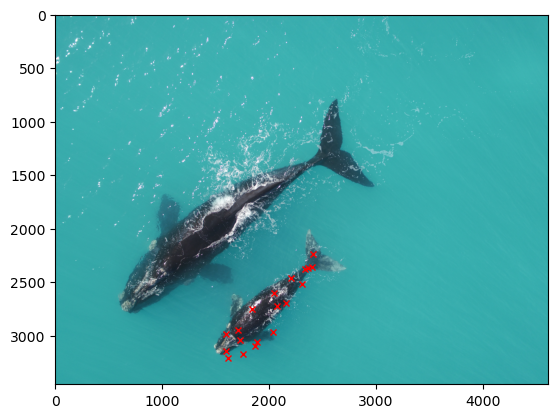

In [135]:
# Visualize the image and keypoints of an image
import matplotlib.pyplot as plt
img = 5
y_actual_coord = []
for i in range(0, k.shape[0], 2):
  xy = []
  xy.append(k[i])
  xy.append(k[i+1])
  y_actual_coord.append(tuple(xy))

plt.imshow(x_train.permute(1,2,0))
for i in range(len(y_actual_coord)):
    plt.plot(y_actual_coord[i][0], y_actual_coord[i][1], 'rx', markersize=5)  # 'rx' indicates red crosses
# Show the plot
plt.show()

In [34]:
input()

 1


'1'